# Proper Orthogonal Decomposition of Schlieren Images

## Big Data Final Project (Spring 2021)

### Written by Elijah LaLonde

This code takes schlieren images and preforms POD on the images, finding the different "modes" that create an orthonormal basis for the ensamble of images. In this code, snapshot POD is implemented. Snapshot POD differs from regular POD in one regard. Traditional POD solves the autocorrelation matrix that is:
$$K=Y\cdot Y^T$$
Where Y is the matrix whose columns correspond to each flattened images. The rows represent the "snapshots" of the floww in time. With some fancy maths, snapshot POD uses the autocorrelation matrix:
$$K=Y^T\cdot Y$$
The eigenvectors of this finds the optimal orthogonal basis for the image set and consequently reduces the size of the matrix you have to handle.

#### Import Libraries

In [1]:
# Libraries for GUI
import numpy as np
import pims
import pandas as pd
from tempfile import TemporaryFile
from scipy.linalg.blas import sgemm # A faster way of doing matrix multiplication
import matplotlib.pyplot as plt
import time
from astrodendro import Dendrogram
from astrodendro import Structure

#### Load the data files

In [2]:
# Name the files to load
bg_file = 'Background AVI.avi'
butane_file = 'Butane Schlieren AVI.avi'

# Load the AVI files with pims
bg_avi = pims.Video(bg_file)
butane_avi = pims.Video(butane_file)

# Convert to greyscale
bg_avi = pims.as_grey(bg_avi) 
butane_avi = pims.as_grey(butane_avi)

#### Preview a background image

Frame([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
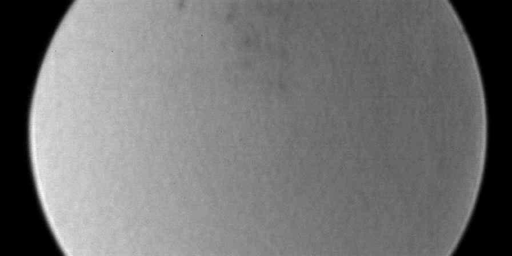

In [3]:
bg_avi[0]

#### Preview an image of the flow

Frame([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
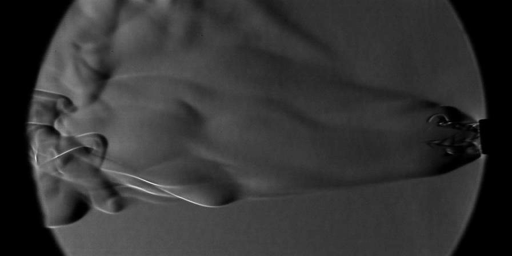

In [4]:
butane_avi[0]

#### Background function

This function pulls the background images from pims and calculates the mean image to use.

In [5]:
def Background(bg_avi,crop_px):
    
    t = len(bg_avi)
    X,Y = np.shape(bg_avi[0])
    Y = Y - 2*crop_px
    
    bg = np.zeros((t,X,Y), dtype = 'float32')
    print('Created background arrray of size:', np.shape(bg))
    i = 0
    for image in bg_avi:
        
        bg[i,:,:] = np.asarray(image[:, crop_px:-crop_px]) # Convert each image to a numpy array and crop accordingly
        i += 1 
        
    print('Calculating the mean background image...')
    bg_image = np.mean(bg, axis = 0) # Calculate the mean background image to be used
    print('Returning array...')
    return bg_image


####  Load_and_BG_subtraction function

This function loads the images from pims as numpy arrays and preforms backgorund subtraction on the images if the variable subtration is set to True.

In [6]:
def Load_and_BG_subtraction(butane_avi,subtract, bg, num_frames, crop_px):
    
    t = num_frames
    X,Y = np.shape(butane_avi[0])
    Y = Y - 2*crop_px
    
    if subtract == True:
        print('Background subtraction selected...')
    
    images = np.zeros((t,X,Y), dtype = 'float32')
    print('Created image arrray of size:', np.shape(images))
    i = 0
    for image in butane_avi[0:num_frames]:
        
        im1 = np.asarray(image[:, crop_px:-crop_px]) # Convert each image to a numpy array and crop accordingly
        if subtract == True:
            images[i,:,:] = (im1 + 255)/(bg + 255) # Do the background subtraction
        else:
            images[i,:,:] = im1 
            
        i += 1 
    if subtract == True:     
        print('Rescaling images...')
        images = 255*images/images.max()
        
    return images

#### Calculate the mean background image

In [7]:
crop_px = 40 # How many pixels to prop off the sides
t1 = time.time()
bg = Background(bg_avi,crop_px)
t2 = time.time()
print('It took', round(t2-t1,3), 'seconds to load and calculate the background image')

Created background arrray of size: (2001, 448, 816)
Calculating the mean background image...
Returning array...
It took 14.882 seconds to load and calculate the background image


#### Prep all the images for analysis

In [8]:
num_frames = 2000 # I don't advise going over 15k images... and thats if you have about 32gb of ram and time 
t3 = time.time()
imgs = Load_and_BG_subtraction(butane_avi, True, bg, num_frames,crop_px) # Call the function to prep the images
t4 = time.time()
print('It took', round(t4-t3,3), 'seconds to load the images and do the background subtraction')
print('It took', round((t4-t1)/60,3), 'minutes to load and prep images', num_frames + 1, 'for POD')

Background subtraction selected...
Created image arrray of size: (2000, 448, 816)
Rescaling images...
It took 20.708 seconds to load the images and do the background subtraction
It took 0.593 minutes to load and prep images 2001 for POD


#### Calculation of dataset mean image

In [9]:
print('Calculating the mean image...')
mean_image = np.mean(imgs, axis = 0) # calculate the mean image
y_bar = mean_image.flatten('F') # We need the mean image flattened todo the POD

Calculating the mean image...


#### Turn images into column vectors for POD analysis and find the autocovariance matrix

Before calculating the autocovariance matrix, you have to subtract the mean from each image so that you are only left with the fluctuating properties. The scipy funciton sgemm is an extremely efficient way of doing matrix multiplication. It is significantly faster than using np.matmul.

In [10]:
# Save the images to be called later
saved_imgs = TemporaryFile()
np.save(saved_imgs, imgs)

y = np.zeros((len(y_bar),num_frames), dtype = 'float32') 

for i in range(num_frames):
    y[:,i] = imgs[i,:,:].flatten('F') # Flatten the images

del imgs

print('Subtracting fluctuating properties...')
for i in range(num_frames):
    y[:,i] = y[:,i] - y_bar # Keep only the fluctiuating properties
    
print('Finding the autocovariance matrix...')
K = sgemm(1.0, y.T, y) # The autocovariance matrix

saved_y = TemporaryFile()
np.save(saved_y, y)
#del y

Subtracting fluctuating properties...
Finding the autocovariance matrix...


#### Calculation of eigenvalues and eigenvectors

In [11]:
print('Solving the eigenvalue problem...')
lamb, v = np.linalg.eig(K) # Solve for the eigenvalues and the eigenvectors

saved_K = TemporaryFile()
np.save(saved_K, K)
del K

I = np.argsort(lamb) # Get the index of the eigenvalues in descending order
lamb = np.sort(lamb) # Sort the eigenvalues in ascending order
lamb = np.flip(lamb).astype(np.float32)  # Flip them so they are now in descending order
lamb[-1] = 0.01 # We need to make sure the last eigenvalue is zero
I = np.flip(I) # Flip them so they are now in descending order
v = v[::-1,list(I)].astype(np.float32) # Sort the eigenvectors accoring to the eigenvalues

E = 0 
E_tot = sum(lamb) # The total energy in the system
E_sum = np.zeros(np.shape(lamb), dtype = 'float32')

for i in range(num_frames): 
    E = E + lamb[i]/E_tot*100 # Calculate the total energy up to frame i
    E_sum[i] = E # Update the cumulativer energy array

norm_lamb = 100*lamb/sum(lamb) # normalize the energy

saved_lamb = TemporaryFile()
np.save(saved_lamb, lamb)
del lamb

saved_norm_lamb = TemporaryFile()
np.save(saved_norm_lamb, norm_lamb)
del norm_lamb

saved_E_sum = TemporaryFile()
np.save(saved_E_sum, E_sum)
del E_sum

t7 = time.time()
print('It took', round((t7-t1)/60,3), 'minutes to Do everything so far')


Solving the eigenvalue problem...
It took 1.363 minutes to Do everything so far


#### Calculate the vectors that become the modal basis

In [12]:
print('Creating basis vectors...')
t8 = time.time()
# Reload y
_ = saved_y.seek(0) # Only needed here to simulate closing & reopening file
y = np.load(saved_y)

a = sgemm(1.0, y, v).astype(np.float32)# This is shorter by like 8 minutes lol

del y

t9 = time.time()

print('Creating basis vectors took', round((t9-t8)/60, 3), 'minutes to find')

Creating basis vectors...
Creating basis vectors took 0.244 minutes to find


#### Normalize the new orthonormal basis

In [13]:
# Reload the eigenvalues
_ = saved_lamb.seek(0) # Only needed here to simulate closing & reopening file
lamb = np.load(saved_lamb)

modes = np.arange(0,num_frames)

t10 = time.time()

X_shape, Y_shape = np.shape(mean_image)
num_modes = len(modes)

u = np.zeros((len(y_bar),num_modes), dtype = 'float32')

j = 0
for mode in modes:
        
    u[:,j] = a[:,mode]/np.sqrt(lamb[mode]) 
    j += 1
    
t11 = time.time()

print('Generating the modes took:', round((t11-t10)/60, 3), 'minutes')
print('Total runtime:', round((t11-t1)/60,3), 'minutes')

Generating the modes took: 0.15 minutes
Total runtime: 1.757 minutes


#### Reshape the selected modes from column vectors back to images

In [14]:
modes_wanted = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
basis_modes = np.zeros((X_shape,Y_shape, len(modes_wanted)), dtype = 'float32')

i = 0
for mode in modes_wanted:
    
    basis_modes[:,:,i] = np.reshape(u[:,mode], (X_shape,Y_shape), order='F')
    
    i += 1

#### Plotting Data

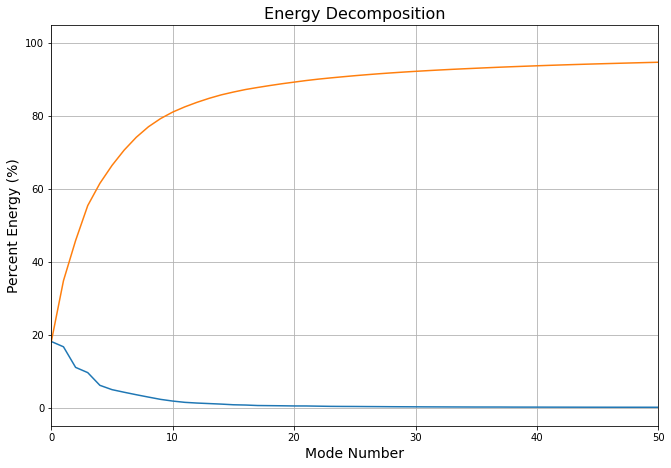

In [15]:
_ = saved_norm_lamb.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb = np.load(saved_norm_lamb)
_ = saved_E_sum.seek(0) # Only needed here to simulate closing & reopening file
E_sum = np.load(saved_E_sum)

figure, ax = plt.subplots(1)
figure.set_size_inches(9,6)
figure.tight_layout(pad=0.5)

plt.plot(norm_lamb)
plt.plot(E_sum)
plt.title('Energy Decomposition', fontsize = 16)
plt.xlabel('Mode Number', fontsize = 14)
plt.ylabel('Percent Energy (%)', fontsize = 14)
plt.xlim([0,50])
plt.grid(True)

It was hypothesised that because a lot of the flame is relativly laminar, that 90% of the total energy would be contained in the first 5 modes. It was quickly discovered that this is not the case. To account for 90% of the energy when using 2000 images, approximatly 30 modes are required.

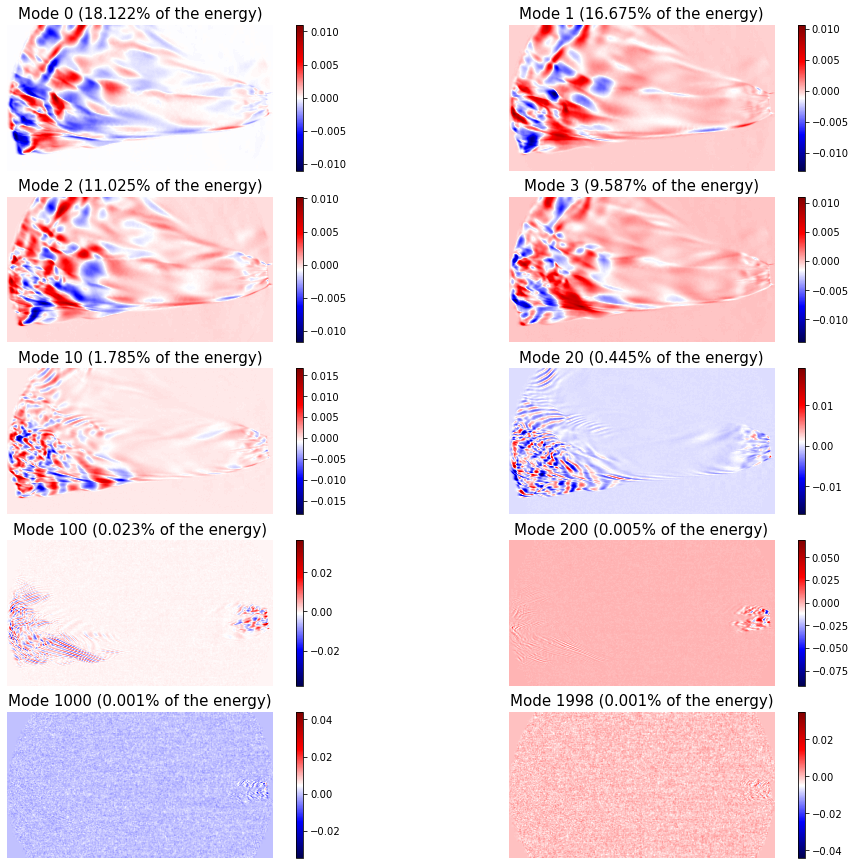

In [16]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(basis_modes[:,:,k], cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        plt.title('Mode ' + str(modes_wanted[k]) + ' (' + str(round(norm_lamb[modes_wanted[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1

It was additionally hypothesised that because the most turbulent part of the flow is at the end of the flame, that the higher modes, which show the smaller scale structures of the flow, would have the energy concentrated at the edge of the flame. Analysis of the modes shows that this is mostly correct. It has been found that while most of the energy is concentrated at the end of the flame for the mid-range modes, there is a higher than expected concentration of energy at the torch nozzle exit and the highest modes have all of their energy concentrated at the nozzle exit.

#### Dengrogam calculation and plotting

Total runtime: 2.349 minutes


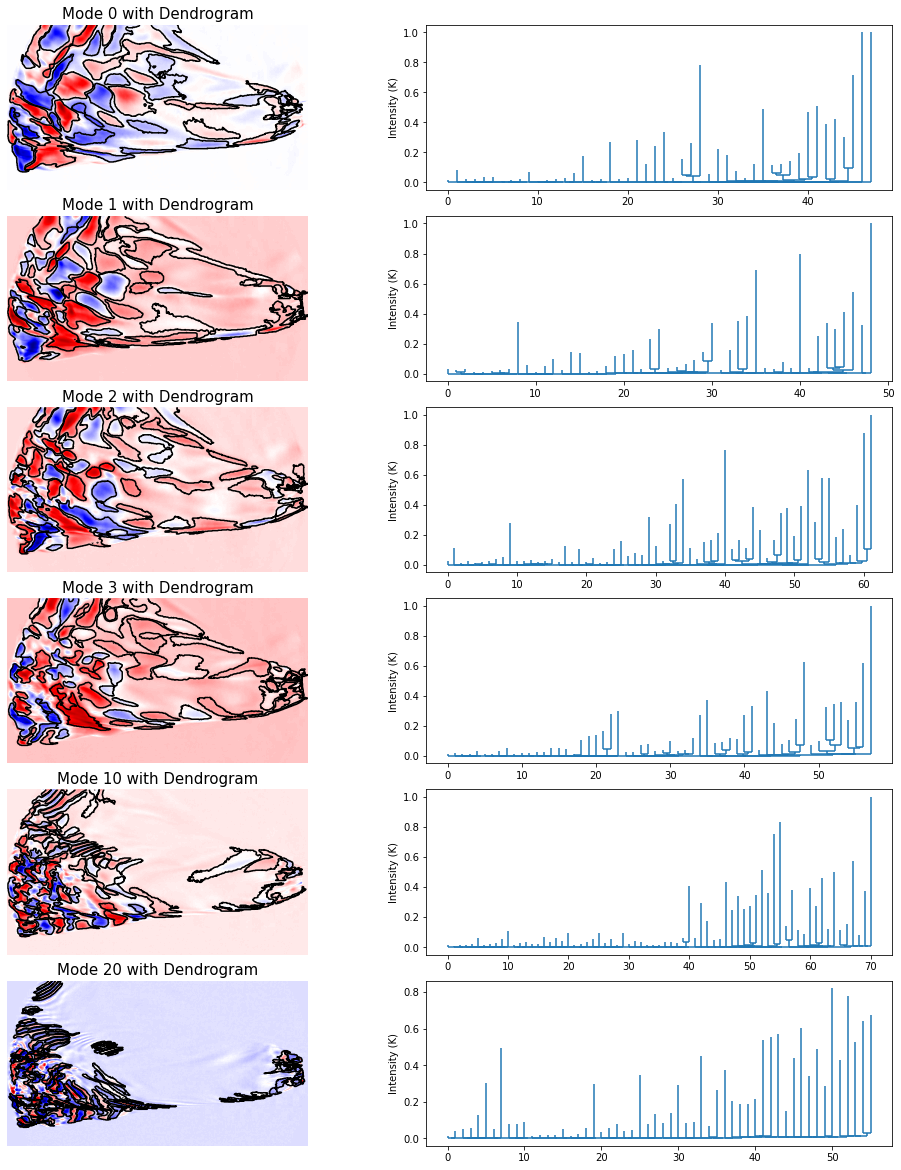

In [17]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes[:,:,i]/abs(basis_modes[:,:,i]).max())**2
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400)
    p = d.plotter()
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves:
                p.plot_contour(plt.gca(), structure=leaf, colors='black')
            
        if j == 1:
            d.plotter().plot_tree(plt.gca())  
            plt.ylabel("Intensity (K)")

        
t12 = time.time()
print('Total runtime:', round((t12-t1)/60,3), 'minutes')